# Carbon Price Forecasting

## Introduction

After listening to a podcast from TILclimate, presented by the MIT Environmental Solutions Initiative, on the topic of carbon offsets, I was interested in digging more into the carbon market. A big question is whether buying credits to offset one's carbon impact on the planet is an effective scheme or not? The latest research suggests that it isn't, but the carbon market keeps expanding, with new carbon registeries opening, new corporate and individual buyers, and new climate projects funded by carbon credits. Just how big will this carbon market become in the next few years? Will it be the [$100 billion market](https://www.wsj.com/articles/rebuilding-trust-in-carbon-offsets-faces-uphill-battle-d7811603?mod=hp_minor_pos17) by 2030 that analysts predict?

That's what I try to uncover in this project forecasting the price of carbon in Emissions Trading Systems (ETS). We look here at the trading demand for carbon credits by predicting carbon prices over time, a market that has the power of shaping our livelihoods.

The data is sourced from the [World Carbon Pricing Database](https://github.com/g-dolphin/WorldCarbonPricingDatabase/tree/master), compiled by Dolphin and Xiahou, economics PhD researchers. It is updated by an active userbase on Github. The exchange rate between national currencies and USD is sourced from the [U.S. Treasury's website](https://fiscaldata.treasury.gov/datasets/treasury-reporting-rates-exchange/treasury-reporting-rates-of-exchange) and the corresponding currency code from [IBAN](https://www.iban.com/currency-codes)'s website.

## Data Pre-Processing

In [33]:
# import packages
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# url used to parse HTML text using requests library
base_url = 'https://github.com/g-dolphin/WorldCarbonPricingDatabase/tree/master/_dataset/data/CO2/national/'
# url used to read the content of the files from Github
file_url = 'https://raw.githubusercontent.com/g-dolphin/WorldCarbonPricingDatabase/master/_dataset/data/CO2/national/'

result = requests.get(base_url)
json_result = json.loads(result.text)

country_files = []
[country_files.append(file_url + country_file['name']) for country_file in json_result['payload']['tree']['items']]    

print(country_files[0])

https://raw.githubusercontent.com/g-dolphin/WorldCarbonPricingDatabase/master/_dataset/data/CO2/national/wcpd_co2_Afghanistan.csv


In [35]:
carbon_df = pd.DataFrame()

for country_file in country_files:
    data = pd.read_csv(country_file)
    data = data.astype({'tax': 'int32', 'ets': 'int32', 'tax_rate_incl_ex_clcu': 'float', 'ets_price': 'float', 'tax_curr_code': 'str'})
    carbon_df = pd.concat([carbon_df, data], axis=0)

In [36]:
carbon_df = carbon_df.dropna(subset=['ets_price'])

In [37]:
carbon_df.drop(carbon_df.columns[carbon_df.apply(lambda col: col.isna().sum() == carbon_df.shape[0])], inplace=True, axis=1)

In [38]:
exch_rate_df = pd.read_csv('https://raw.githubusercontent.com/chloelubin/carbon_price_forecasting/main/_datasets/exchange_rate_2005_2022.csv')

carbon_df = pd.merge(
    carbon_df, exch_rate_df, how='left', left_on=['year', 'ets_curr_code'], right_on=['recorded_year', 'country_code']
)

In [39]:
carbon_df['ets_price_usd'] = carbon_df['ets_price'] / carbon_df['exchange_rate']

In [40]:
carbon_df.jurisdiction.unique()

array(['Austria', 'Belgium', 'Bulgaria', 'China', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Kazakhstan', 'Korea, Rep.', 'Latvia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovak Republic',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom'],
      dtype=object)

In [63]:
[carbon_df.groupby(['jurisdiction', 'year'])['ets_price_usd'].nunique() != 1] == True

False

In [68]:
carbon_df = carbon_df.drop_duplicates(subset=['jurisdiction','year','ets_price','ets_price_usd','exchange_rate'])

In [69]:
carbon_df.describe()

,year,tax,ets,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,ets_price,recorded_year,exchange_rate,ets_price_usd
count,569.000000,569.000000,569.0,65.000000,66.0,65.000000,569.000000,569.000000,569.000000,569.000000
mean,2013.970123,0.115993,1.0,10.816077,0.0,10.816077,293.023357,2013.970123,17.463025,21.664172
std,5.057851,0.320498,0.0,23.324990,0.0,23.324990,2539.282884,5.057851,129.041091,20.525279
min,2005.000000,0.000000,1.0,0.140000,0.0,0.140000,0.000000,2005.000000,0.680000,0.000000
25%,2010.000000,0.000000,1.0,0.290000,0.0,0.290000,5.950000,2010.000000,0.759000,7.238443
50%,2014.000000,0.000000,1.0,2.000000,0.0,2.000000,14.340000,2014.000000,0.822000,18.142202
75%,2018.000000,0.000000,1.0,4.940000,0.0,4.940000,24.760000,2018.000000,0.890000,25.454545
max,2022.000000,1.000000,1.0,96.000000,0.0,96.000000,30163.910000,2022.000000,1203.210000,86.346154


In [70]:
carbon_df.shape

(569, 20)

In [71]:
carbon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 43625
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   jurisdiction           569 non-null    object 
 1   year                   569 non-null    int64  
 2   ipcc_code              569 non-null    object 
 3   Product                568 non-null    object 
 4   tax                    569 non-null    int32  
 5   ets                    569 non-null    int32  
 6   tax_id                 66 non-null     object 
 7   tax_rate_excl_ex_clcu  65 non-null     float64
 8   tax_ex_rate            66 non-null     float64
 9   tax_rate_incl_ex_clcu  65 non-null     float64
 10  tax_curr_code          569 non-null    object 
 11  ets_id                 569 non-null    object 
 12  ets_price              569 non-null    float64
 13  ets_curr_code          569 non-null    object 
 14  recorded_date          569 non-null    object 
 15  reco

In [72]:
carbon_df.Product.unique()

array(['Coal', nan], dtype=object)

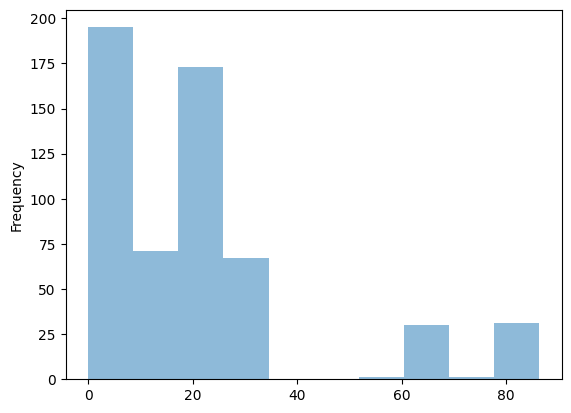

In [73]:
carbon_df.ets_price_usd.plot.hist(bins=10, alpha=0.5);

In [74]:
carbon_df.to_csv('carbon_price_all_countries.csv', index=False)

## Exploratory Data Analysis

In [56]:
carbon_df[carbon_df.jurisdiction == 'China']

,jurisdiction,year,ipcc_code,Product,tax,ets,tax_id,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,tax_curr_code,ets_id,ets_price,ets_curr_code,recorded_date,recorded_year,country_name,country_code,exchange_rate,ets_price_usd
3961,China,2021,1A1A1,Coal,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3962,China,2021,1A1A1,Natural gas,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3963,China,2021,1A1A1,Oil,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3964,China,2021,1A1A2,Coal,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3965,China,2021,1A1A2,Natural gas,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3966,China,2021,1A1A2,Oil,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3967,China,2021,1A1A3,Coal,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3968,China,2021,1A1A3,Natural gas,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667
3969,China,2021,1A1A3,Oil,0,1,NaN,NaN,NaN,NaN,nan,chn_ets,46.61,CNY,12/31/21,2021,China,CNY,6.373,7.313667


## Data Modeling

## Model Diagnostics

## Conclusion

## References

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9859446/
